In [37]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from prophet.diagnostics import cross_validation, performance_metrics
from suntime import Sun, SunTimeException
from datetime import timedelta
import ephem
import xgboost as xgb
from sklearn.metrics import r2_score

In [38]:
def create_lagged_features(df, column, lags):
    for lag in range(1, lags + 1):
        df[f'{column}_lag{lag}'] = df[column].shift(lag)
    return df

In [39]:
def get_data():
    file_path = '/Users/mubashirahmad/Library/CloudStorage/OneDrive-UniversityofHertfordshire/BDTI-Shared-Resources/Projects/On-Going/PowerBox/powerbox/powerbox/Data/processed_datasets/SI_SP_merged_filtered.csv'
    data = pd.read_csv(file_path)
    data['System Production (W)'] = data['System Production (W)'] / 1000
    n = len(data)
    train_size = int(n * 0.80)
    valid_size = int(n * 0.15)

    train_data = data.iloc[:train_size]
    valid_data = data.iloc[train_size:train_size + valid_size]
    test_data = data.iloc[train_size + valid_size:]
    print('Training Set: ',len(train_data),'Validation Set: ', len(valid_data),'Test Set: ', len(test_data))
    
    return train_data, valid_data, test_data

In [40]:
def data_init():
    train, valid, test = get_data()  # Assuming get_data() is your custom data loader function
    train = create_lagged_features(train, 'System Production (W)', 3)
    valid = create_lagged_features(valid, 'System Production (W)', 3)

    # Drop rows with NaN values created by lagging
    train = train.dropna().reset_index(drop=True)
    valid = valid.dropna().reset_index(drop=True)
    
    # Select relevant columns
    columns = [
        'Time', 'System Production (W)', 'System Production (W)_lag1',
        'System Production (W)_lag2', 'System Production (W)_lag3',
        'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_UV_INDEX', 'T2MWET', 'ALLSKY_SFC_PAR_TOT',
        'ALLSKY_SRF_ALB', 'CLRSKY_SFC_SW_DWN', 'T2M', 'ALLSKY_KT',
        'CLRSKY_SFC_PAR_TOT', 'ALLSKY_SFC_SW_DIFF', 'ALLSKY_SFC_SW_DNI',
        'ALLSKY_SFC_UVB', 'ALLSKY_SFC_UVA'
    ]
    
    # Convert Time column to datetime and set as index
   
    train['Time'] = pd.to_datetime(train['Time'])
    train.set_index('Time', inplace=True)
    train.asfreq('h')
    
    valid['Time'] = pd.to_datetime(valid['Time'])
    valid.set_index('Time', inplace=True)
    valid.asfreq('h')
    
    # Exogenous features
    exog_columns = columns[2:]  # All columns except 'Time' and target variable

    # Scale the target variable
    scaler = RobustScaler()
    train['System Production (W)'] = scaler.fit_transform(train[['System Production (W)']])
    valid['System Production (W)'] = scaler.transform(valid[['System Production (W)']])

    # Scale the exogenous variables
    exog_scaler = RobustScaler()
    train_exog = exog_scaler.fit_transform(train[exog_columns])
    valid_exog = exog_scaler.transform(valid[exog_columns])

    return train, valid, train_exog, valid_exog, scaler, exog_scaler







In [41]:
# Initialize data
train, valid, train_exog, valid_exog, scaler, exog_scaler = data_init()
# Step 3: Model Building
# Determine p, d, q
p = range(0, 3)  # Adjust based on PACF
q = range(0, 3)  # Adjust based on ACF
pdq = list(itertools.product(p, [0], q))
seasonal_pdq = [(x[0], 0, x[1], 24) for x in itertools.product(range(0, 2), range(0, 2))]  # Seasonal period is 24

# Fit the Seasonal ARIMA model
best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_mdl = SARIMAX(train['System Production (W)'],
                               order=param,
                               seasonal_order=param_seasonal,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
            res = temp_mdl.fit(disp=False)
            print(param, ' : ', param_seasonal, " AIC ", res.aic)
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = param
                best_seasonal_order = param_seasonal
                best_mdl = res
        except:
            continue

print('Best ARIMA order:', best_order)
print('Best Seasonal ARIMA order:', best_seasonal_order)
print('Best AIC:', best_aic)

Training Set:  15184 Validation Set:  2847 Test Set:  949


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(0, 0, 0)  :  (0, 0, 0, 24)  AIC  41985.10674955043
(0, 0, 0)  :  (0, 0, 1, 24)  AIC  31918.797652339912


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(0, 0, 0)  :  (1, 0, 0, 24)  AIC  18798.505716505348


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(0, 0, 0)  :  (1, 0, 1, 24)  AIC  10968.682976517935


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(0, 0, 1)  :  (0, 0, 0, 24)  AIC  26898.965840165023


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(0, 0, 1)  :  (0, 0, 1, 24)  AIC  20272.234043916458


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(0, 0, 1)  :  (1, 0, 0, 24)  AIC  11640.903965905853


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(0, 0, 1)  :  (1, 0, 1, 24)  AIC  3938.4144651127576


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(0, 0, 2)  :  (0, 0, 0, 24)  AIC  18849.66800756075


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(0, 0, 2)  :  (0, 0, 1, 24)  AIC  14934.614651589221


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(0, 0, 2)  :  (1, 0, 0, 24)  AIC  9641.060696182609


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(0, 0, 2)  :  (1, 0, 1, 24)  AIC  2170.489504746985


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(1, 0, 0)  :  (0, 0, 0, 24)  AIC  12730.731110127468


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(1, 0, 0)  :  (0, 0, 1, 24)  AIC  10138.293703060746


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(1, 0, 0)  :  (1, 0, 0, 24)  AIC  8013.357486146024


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(1, 0, 0)  :  (1, 0, 1, 24)  AIC  1598.3874645220164


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(1, 0, 1)  :  (0, 0, 0, 24)  AIC  10878.529434476026


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(1, 0, 1)  :  (0, 0, 1, 24)  AIC  9259.036627433943


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(1, 0, 1)  :  (1, 0, 0, 24)  AIC  7796.584886480775


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(1, 0, 1)  :  (1, 0, 1, 24)  AIC  1461.2774050784376


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(1, 0, 2)  :  (0, 0, 0, 24)  AIC  10450.180806167107


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(1, 0, 2)  :  (0, 0, 1, 24)  AIC  9092.806683024502


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(1, 0, 2)  :  (1, 0, 0, 24)  AIC  7793.313025870582


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(1, 0, 2)  :  (1, 0, 1, 24)  AIC  1463.7736534306218


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(2, 0, 0)  :  (0, 0, 0, 24)  AIC  10282.485625108722


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(2, 0, 0)  :  (0, 0, 1, 24)  AIC  9043.463318112506


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(2, 0, 0)  :  (1, 0, 0, 24)  AIC  7788.352353487413


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(2, 0, 0)  :  (1, 0, 1, 24)  AIC  1467.0997492636436


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(2, 0, 1)  :  (0, 0, 0, 24)  AIC  10041.496428224713


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(2, 0, 1)  :  (0, 0, 1, 24)  AIC  8852.383048086765


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(2, 0, 1)  :  (1, 0, 0, 24)  AIC  7774.477773907085


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(2, 0, 1)  :  (1, 0, 1, 24)  AIC  1463.0046681993222


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(2, 0, 2)  :  (0, 0, 0, 24)  AIC  10024.045801301589


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(2, 0, 2)  :  (0, 0, 1, 24)  AIC  8832.70321477767


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


(2, 0, 2)  :  (1, 0, 0, 24)  AIC  7746.665672270447


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 2)  :  (1, 0, 1, 24)  AIC  1463.868036521857
Best ARIMA order: (1, 0, 1)
Best Seasonal ARIMA order: (1, 0, 1, 24)
Best AIC: 1461.2774050784376


In [42]:
# best_order = (1,0,1)

train, valid, train_exog, valid_exog, scaler, exog_scaler = data_init()
# Fit the SARIMAX model
model = SARIMAX(train['System Production (W)'],
                exog=train_exog,
                order=best_order,
                seasonal_order=best_seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False) #maxiter = 200



Training Set:  15184 Validation Set:  2847 Test Set:  949


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [46]:
# Forecasting
forecast = model_fit.get_forecast(steps=len(valid), exog=valid_exog)
forecast_index = valid.index
forecast_values = forecast.predicted_mean

# Inverse transform the forecasted values
forecast_inversed = scaler.inverse_transform(forecast_values.values.reshape(-1, 1))
valid_inversed = scaler.inverse_transform(valid[['System Production (W)']])
train_inversed = scaler.inverse_transform(train[['System Production (W)']])
# Handle potential NaN values
if np.any(np.isnan(forecast_inversed)):
    print("Warning: NaN values detected in the forecast. Investigate further.")
    forecast_inversed = np.nan_to_num(forecast_inversed)  # Replace NaNs with 0 or another strategy


forecast_inversed = np.where(forecast_inversed < 0, 0, forecast_inversed)
# Evaluate the forecast accuracy
mae = mean_absolute_error(valid_inversed, forecast_inversed)
rmse = np.sqrt(mean_squared_error(valid_inversed, forecast_inversed))

r2 = r2_score(valid_inversed, forecast_inversed)
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

Mean Absolute Error: 31.338662755904352
Root Mean Squared Error: 62.47197282982261
R² Score: 0.8692646725329557


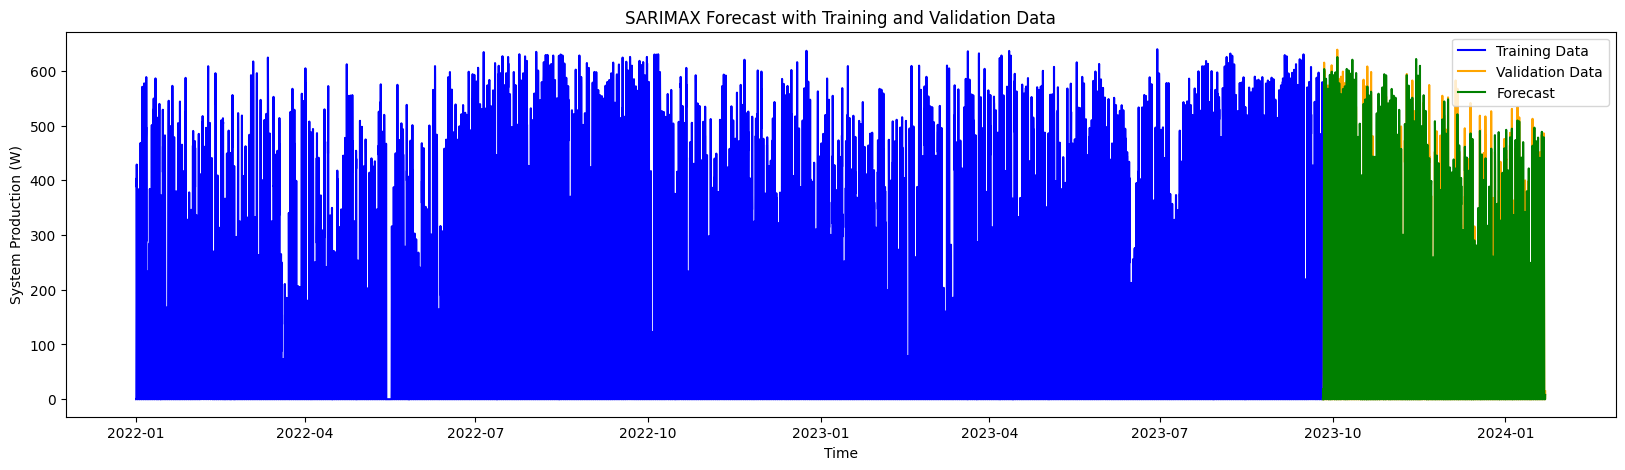

In [47]:
fig, ax = plt.subplots(figsize=(20, 5))

# Plot the training data
ax.plot(train.index, train_inversed, label='Training Data', color='blue')

# Plot the validation data
ax.plot(valid.index, valid_inversed, label='Validation Data', color='orange')

# Plot the forecast data
ax.plot(valid.index, forecast_inversed.flatten(), label='Forecast', color='green')

# Add labels, title, and legend
ax.set_xlabel('Time')
ax.set_ylabel('System Production (W)')
ax.set_title('SARIMAX Forecast with Training and Validation Data')
ax.legend()

plt.show()

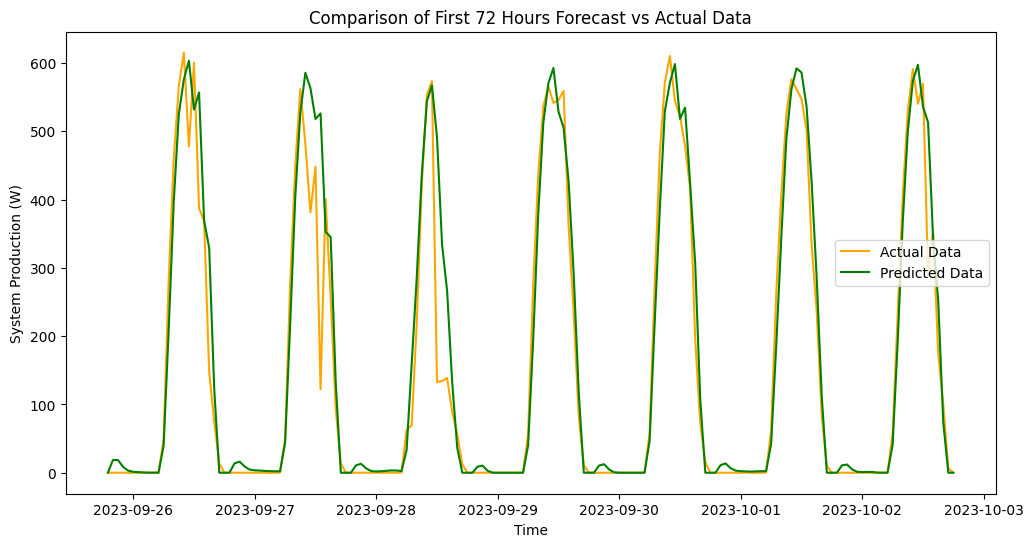

In [48]:
# Select the first 72 hours for comparison
first_72_hours_valid = valid.iloc[:168]
first_72_hours_forecast = forecast_inversed[:168].flatten()

# Plotting the first 72 hours of actual vs. predicted values
plt.figure(figsize=(12, 6))

# Plot the validation (actual) data
plt.plot(first_72_hours_valid.index, valid_inversed[:168], label='Actual Data', color='orange')

# Plot the forecasted data
plt.plot(first_72_hours_valid.index, first_72_hours_forecast, label='Predicted Data', color='green')

# Customize the plot
plt.title('Comparison of First 72 Hours Forecast vs Actual Data')
plt.xlabel('Time')
plt.ylabel('System Production (W)')
plt.legend()

# Display the plot
plt.show()